In [10]:
from io import StringIO
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
import xml.etree.ElementTree as et
import zeep
from zeep.cache import SqliteCache

In [11]:
fromDate, ToDate = "2024-01-01", "2024-12-31"
dates = pd.date_range(start=fromDate, end=ToDate, freq="MS")

df_sales = pd.DataFrame({
    'sales': [5350, 5450, 5500, 4500, 4400, 3900, 3800, 4000, 4500, 4900, 5000, 5500]
},   index = dates
).sort_index()

In [12]:
def get_cbr_key_rate(fromDate:str, ToDate:str) -> pd.DataFrame:
    """
    Parsing key rates within a range of dates.
    ToDate must accept DD inputs ending on the last day of the month.
    """
    service_url = "https://www.cbr.ru/DailyInfoWebServ/DailyInfo.asmx?WSDL"
    transport = zeep.Transport(cache=SqliteCache())
    cbr_client = zeep.Client(wsdl=service_url, transport=transport)
    response = cbr_client.service.KeyRateXML(fromDate=fromDate, ToDate=ToDate)
    df = pd.read_xml(StringIO(et.tostring(element=response, encoding='unicode')))
    df["DT"] = df["DT"].str.replace(pat="T00:00:00+03:00", repl="", regex=False)
    df["DT"] = pd.to_datetime(df["DT"])
    df = df.set_index(keys="DT").sort_index()
    df = df.groupby(df.index.to_period('M')).agg(lambda x: x.mode().iloc[0]) #Looking for the most frequent key rate in month
    df.index = df.index.to_timestamp()
    return df

def key_rate_and_sales(func:"a function to get the key rates") -> pd.DataFrame:
    '''Creating a dataframe with sales and key rates'''
    df = pd.DataFrame(data = {"sales": df_sales["sales"], "rate": func["Rate"]}, index=func.index)
    return df

In [13]:
sales_rates_2024 = key_rate_and_sales(func = get_cbr_key_rate(fromDate=fromDate, ToDate=ToDate))

Forcing soap:address location to HTTPS
Forcing soap:address location to HTTPS


In [14]:
sales_rates_2024

,sales,rate
DT,,
2024-01-01,5350,16.0
2024-02-01,5450,16.0
2024-03-01,5500,16.0
2024-04-01,4500,16.0
2024-05-01,4400,16.0
2024-06-01,3900,16.0
2024-07-01,3800,16.0
2024-08-01,4000,18.0
2024-09-01,4500,19.0


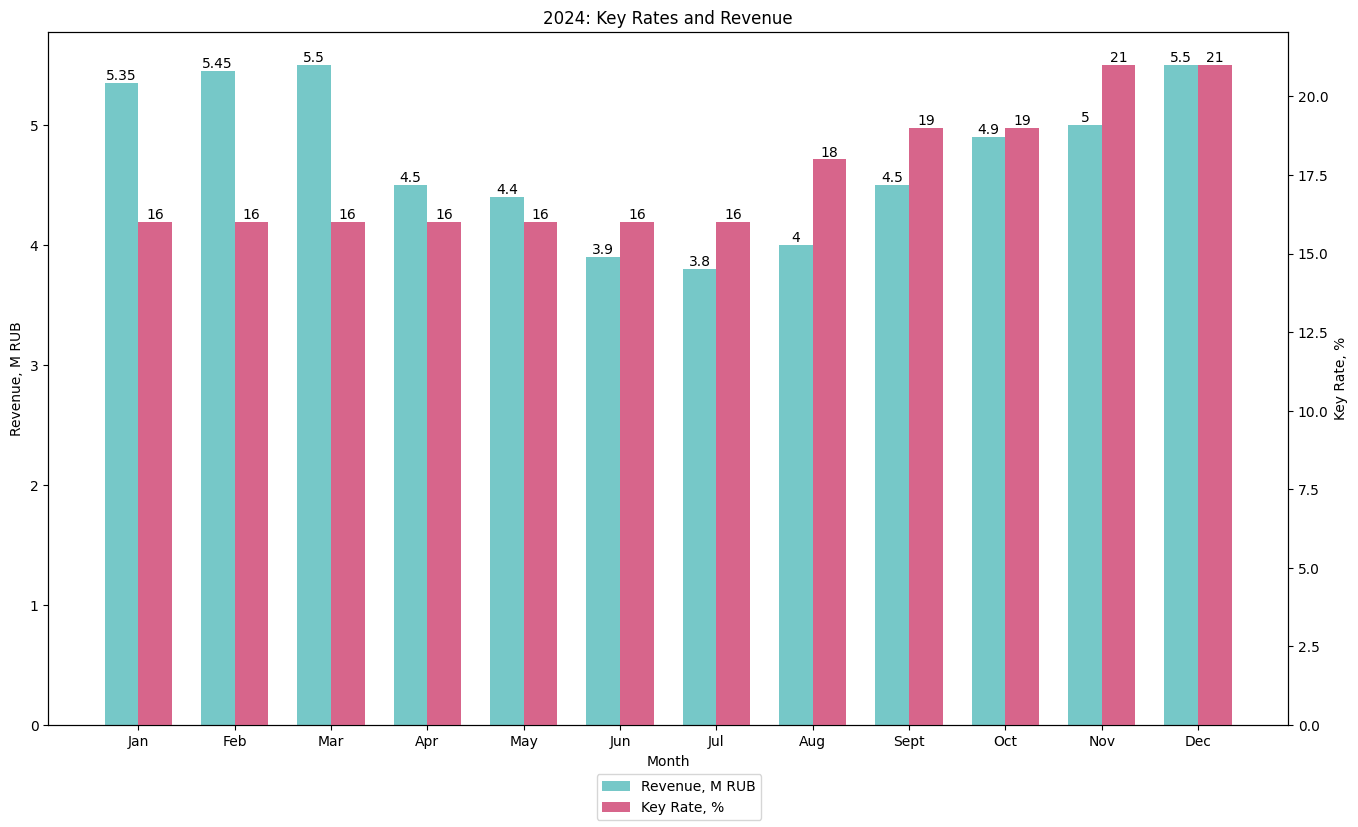

In [15]:
months = ("Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sept", "Oct", "Nov", "Dec")
bar_width = 0.35

fig, ax = plt.subplots(figsize = (16, 9))
ax2 = ax.twinx() # secondary y-axis

sales_bar = ax.bar(x = np.arange(len(months)) - bar_width/2, height = np.array(sales_rates_2024["sales"]/1000),
                    width = bar_width, label = "Revenue, M RUB", color = "#76c8c8")

rate_bar = ax2.bar(x = np.arange(len(months)) + bar_width/2, height = np.array(sales_rates_2024["rate"]),
                width = bar_width, label = "Key Rate, %", color = "#d7658b")

ax.set_ylabel("Revenue, M RUB")
ax2.set_ylabel("Key Rate, %")

ax.set_xticks(np.arange(len(months)))
ax.set_xticklabels(months)
ax.set_xlabel("Month")

fig.legend(loc=8)
ax.set_title(fromDate[0:4]+": Key Rates and Revenue")

ax.bar_label(container=sales_bar)
ax2.bar_label(container=rate_bar)

plt.show()

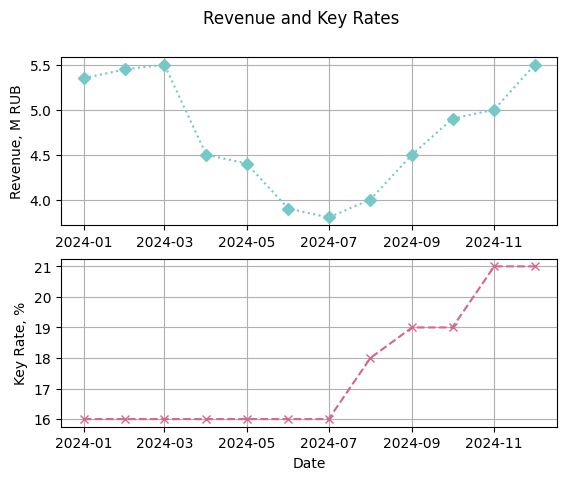

In [16]:
fig2, (ax1, ax2) = plt.subplots(2, 1)
fig2.suptitle('Revenue and Key Rates')

ax1.plot(sales_rates_2024["sales"]/1000, marker='D', linestyle = ':', color = "#76c8c8")
ax1.set_ylabel("Revenue, M RUB")
ax1.grid()

ax2.plot(sales_rates_2024["rate"], marker='x', linestyle = '--', color = "#d7658b")
ax2.set_xlabel('Date')
ax2.set_ylabel('Key Rate, %')
ax2.grid()

plt.show()

Is there any connection between the revenue📊 and the key rates📈📉?

Hypothesis Testing:

H_0: There is NO relation between the revenue and key rates.

H_1:There IS depedence between the revenue and key rates

In [17]:
alpha = 0.05
cor_coef, p_value = stats.pearsonr(x=sales_rates_2024['rate'], y=sales_rates_2024["sales"])
print(f"Alpha level = {alpha}. P-value - {np.round(a=p_value, decimals=2)}; correlation coefficient - {np.round(a=cor_coef, decimals=2)}")

Alpha level = 0.05. P-value - 0.44; correlation coefficient - 0.25


The positive correlation coefficient means that as the key rate increases, volumes increase too.

The corrlation coefficient of 0.25 on a 0-1 scale tells about neglegible relations between 
the revenue and key rates.

We do NOT reject zero hypothesis at p-value of 0.44 and significance level of 0.05. That indicates strong evidence for NO relations between the revenue and key rates.